In [1]:
from matplotlib import pylab
from pylab import *

import pickle
import random
import os
from collections import Counter

import nltk
import pylab as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.utils.data as data
from torch.nn.utils.rnn import pack_padded_sequence

from sklearn.metrics import hamming_loss

model_name = "Master ResNet-152 Multilabel"

# In this section we load the HARRISON data set which we have extracted into the data directory

with open("./HARRISON-Dataset/HARRISON/data_list.txt") as f:
    data_list = f.read().splitlines()
with open("./HARRISON-Dataset/HARRISON/tag_list.txt") as f:
    tag_list = f.read().splitlines()

print(data_list[0])
print(tag_list[0])

instagram_dataset/sea/image_50.jpg
sea instapic instagram trip travel 


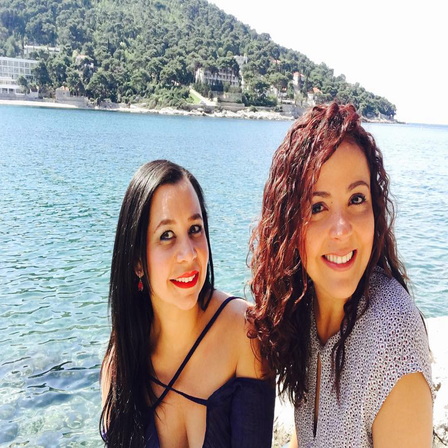

#sea, #instapic, #instagram, #trip, #travel


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thiru\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Visualizing the data
image = Image.open("./HARRISON-Dataset/HARRISON/HARRISON_full//HARRISON/" + data_list[0])
image = image.resize((448, 448), Image.Resampling.LANCZOS)
display(image)
print("#" + ", #".join(tag_list[0].split(" "))[:-3])

import nltk
nltk.download('punkt')


### A vocabulary object contains supports three main operations:
\begin{enumerate} \item Get the integer representation of a word \item Get the word representation of an integer \item Get the number of items in the vocabulary \end{enumerate}
To build a vocabulary, call build_vocabulary and pass in a list of tagged sequences and the minimum number of times a tag must appear for it to be included in the vocabulary

In [3]:
# Importing nltk library and downloading the 'punkt' tokenizer
import nltk
nltk.download('punkt_tab')

# Defining the Vocabulary class to handle word-to-index and index-to-word mappings
class Vocabulary(object):
    def __init__(self):
        # A dictionary to map words to their corresponding indices
        self.word_to_index = {}
        # A list to store words, enabling reverse lookup by index
        self.index_to_word = []
        # Tracks the current index for new words
        self.index = 0
    
    # Method to add a new word to the vocabulary
    def add_word(self, word):
        if not word in self.word_to_index:
            # Map the word to the current index and add it to the list
            self.word_to_index[word] = self.index
            self.index_to_word.append(word)
            # Increment the index for the next word
            self.index += 1
        else:
            # Raise an error if the word already exists in the vocabulary
            raise ValueError("Word %s is already in the vocabulary!" % word)
    
    # Overloading the call operator to handle word or index queries
    def __call__(self, word):
        if type(word) == str:  # If input is a string (word)
            # Return "<UNK>" index if word is not found
            if word not in self.word_to_index:
                return self.word_to_index["<UNK>"]
            return self.word_to_index[word]
        elif type(word) == int:  # If input is an integer (index)
            # Check if the index is valid
            if self.index <= word:
                raise ValueError("Index %s is out of bounds!" % word)
            return self.index_to_word[word]
        else:
            # Raise an error for invalid input types
            raise ValueError("Only strings and integers are accepted inputs!")
    
    # Return the size of the vocabulary
    def __len__(self):
        return self.index

# Function to build the vocabulary from a list of tags
def build_vocabulary(tag_list, min_occurrences, progress_bar=True):
    # Counter to track word frequencies
    from collections import Counter
    counter = Counter()
    # Iterate over the tag list, tokenize each entry, and update the counter
    for tags in (tqdm_notebook(tag_list) if progress_bar else tag_list):
        tokens = nltk.tokenize.word_tokenize(tags.lower())  # Tokenize and convert to lowercase
        counter.update(tokens)
        
    # Include only words that appear at least 'min_occurrences' times
    words = [word for word, count in counter.items() if count >= min_occurrences]
    
    # Create an instance of the Vocabulary class
    vocab = Vocabulary()
    # Add a special token for unknown words
    vocab.add_word("<UNK>")
    
    # Add all the frequent words to the vocabulary
    for word in words:
        vocab.add_word(word)
    return vocab

# Example usage: Build a vocabulary from a list of tags with a minimum occurrence threshold of 20
vocabulary = build_vocabulary(tag_list=[tags for tags in tag_list], min_occurrences=20)

# Print the size of the created vocabulary
print(len(vocabulary))


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\thiru\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
C:\Users\thiru\AppData\Local\Temp\ipykernel_14216\3001234112.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tags in (tqdm_notebook(tag_list) if progress_bar else tag_list):


  0%|          | 0/3770 [00:00<?, ?it/s]

170


### Batching The Data
The data is grouped by the number of tags associated with each image and separated within a BatchedData object, which handles holding batches of a specified batch_size. Each batch only holds images with the same number of tags and there are no batches that are smaller than batch_size.

In [4]:
# Define the batch size
batch_size = 32

# Class to handle and store batched data
class BatchedData(object):
    def __init__(self, batch_size):
        # List to store batches of data
        self.batched_data = []
        # Current index to track batches
        self.index = 0
        # Size of each batch
        self.batch_size = batch_size

    # Method to add a batch to the stored list
    def add_batch(self, batch):
        # Only add the batch if its size matches the defined batch size
        if len(batch) == self.batch_size:
            self.batched_data.append(batch)
        else:
            # Print a warning message if the batch size is incorrect
            print("Not the correct size batch!")

    # Overloading the call operator to access a specific batch by index
    def __call__(self, index):
        # Return an empty list if the index is out of range
        if not index < len(self.batched_data):
            return []
        return self.batched_data[index]

    # Return the total number of batches
    def __len__(self):
        return len(self.batched_data)

# Function to batch data from a list of tags
def batch_data(tag_list, batch_size, progress_bar=True):
    # Dictionary to group tags by the number of tokens in each tag
    batched_map = {}
    
    # Iterate over the tag list, tokenize each tag, and group by token length
    for i, tags in enumerate(tqdm_notebook(tag_list) if progress_bar else tag_list):
        tokens = nltk.tokenize.word_tokenize(tags.lower())  # Tokenize and convert to lowercase
        num_tags = len(tokens)  # Get the number of tokens in the tag
        
        # Initialize a list for the token length if it doesn't exist in the map
        if num_tags not in batched_map.keys():
            batched_map[num_tags] = []
        
        # Append the index of the tag to the corresponding token-length group
        batched_map[num_tags].append(i)
    
    # Create an instance of the BatchedData class
    batched_data = BatchedData(batch_size)
    
    # Iterate through the grouped tags in the map
    for i, batch in batched_map.items():
        if len(batch) >= batch_size:  # Ensure there are enough tags to create batches
            random.shuffle(batch)  # Randomly shuffle the tags
            # Create batches and add them to batched_data
            for j in range(len(batch) // batch_size):
                batched_data.add_batch(batch[batch_size * j : batch_size * (j + 1)])
    
    # Shuffle the list of batches to randomize their order
    random.shuffle(batched_data.batched_data)
    
    return batched_data

# Example usage: Create batches from a tag list with a batch size of 32
batched_data = batch_data(tag_list, batch_size)


C:\Users\thiru\AppData\Local\Temp\ipykernel_14216\1269975961.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, tags in enumerate(tqdm_notebook(tag_list) if progress_bar else tag_list):


  0%|          | 0/3770 [00:00<?, ?it/s]

### Splitting Into Test and Training Data
All of the batched data is split into training and testing data in a 75/25 split respectively.

In [5]:
def create_splits(batched_data):
    training_data = BatchedData(batched_data.batch_size)
    test_data = BatchedData(batched_data.batch_size)
    for batch in batched_data.batched_data:
        num = random.randint(1, 101)
        if num <= 75:
            training_data.add_batch(batch)
        else:
            test_data.add_batch(batch)
    return training_data, test_data

batched_train_data, batched_test_data = create_splits(batched_data)

### The Transformations
We define two different transformations:
\begin{enumerate} \item The training transformation, which has augmentations to reduce overfitting \item The testing transformation, which simply loads the image \end{enumerate}
We normalize as specified by the PyTorch website

In [6]:
training_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

testing_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

### The Data Loader
This is a PyTorch compatible data loader that support multi-threading. It returns at every iteration
\begin{enumerate} \item A batch of images in the form of a Tensor \item A batch of the corresponding tags in integer form as a Tensor \item A list of the indexes of the image in the data set \end{enumerate}

In [7]:
# Custom Dataset class to handle image-tag pairs with batching and transformations
class CustomDataSet(data.Dataset):
    def __init__(self, tag_list, batched_indexes, vocabulary, transform=None):
        """
        Initializes the dataset with the provided data and parameters.
        
        Args:
        - tag_list: List of tags (strings) associated with images.
        - batched_indexes: Indices of images grouped into batches.
        - vocabulary: Vocabulary object for mapping words to indices.
        - transform: Transformations to be applied to images (e.g., resizing, normalization).
        """
        self.tag_list = tag_list
        self.batched_indexes = batched_indexes
        self.vocabulary = vocabulary
        self.transform = transform

    def __getitem__(self, index):
        """
        Fetches a batch of images, their associated tags, and their IDs.

        Args:
        - index: Index of the batch to fetch.

        Returns:
        - images: Tensor of stacked images in the batch.
        - tags: Tensor of tokenized tags corresponding to the images.
        - image_ids: List of IDs for the images in the batch.
        """
        images = []
        tags = []
        image_ids = []
        
        # Loop through the IDs in the batch and process each image
        for id in self.batched_indexes(index):
            # Open the image file and convert it to RGB format
            image = Image.open("./HARRISON-Dataset/HARRISON/HARRISON_full/HARRISON/" + data_list[id]).convert('RGB')
            
            # Apply any specified transformations (e.g., resizing, normalization)
            if self.transform is not None:
                image = self.transform(image)
            
            images.append(image)
            
            # Tokenize and sort the tag associated with the image
            image_tag = sorted(nltk.tokenize.word_tokenize(self.tag_list[id].lower()))
            
            # Convert tokens to vocabulary indices and add special tokens (<SOS>, <EOS>)
            tags.append([self.vocabulary("<SOS>")] + \
                        sorted([self.vocabulary(tag) for tag in image_tag]) + \
                        [self.vocabulary("<EOS>")])
            
            # Append the image ID to the list
            image_ids.append(id)
        
        # Stack all processed images into a single tensor
        images = torch.stack(images, 0)
        
        # Convert tags to a tensor of type LongTensor
        tags = torch.LongTensor(tags)
        
        # Enable gradient computation for the image tensor
        images.requires_grad_(True)
        
        return images, tags, image_ids

    def __len__(self):
        """
        Returns the number of batches in the dataset.
        """
        return len(self.batched_indexes)

# Collate function to organize data into mini-batches
def collate_fn(data):
    """
    Groups data into mini-batches for training or testing.

    Args:
    - data: List of tuples (images, tags, image_ids) from the dataset.

    Returns:
    - A tuple containing the first batch of images, tags, and image IDs.
    """
    # Unpack the data into separate lists for images, tags, and IDs
    images, tags, image_ids = zip(*data)
    
    # Return the first batch (assumes a single batch is passed in)
    return images[0], tags[0], image_ids[0]

# Function to create data loaders for training and testing
def get_loader(tag_list, batched_indexes, vocabulary, transform, shuffle=False, num_workers=2):
    """
    Creates a data loader for handling batches of data during training or testing.

    Args:
    - tag_list: List of tags associated with images.
    - batched_indexes: Indices grouped into batches.
    - vocabulary: Vocabulary object for mapping words to indices.
    - transform: Transformations to apply to images.
    - shuffle: Whether to shuffle the dataset.
    - num_workers: Number of worker processes for loading data.

    Returns:
    - data_loader: A PyTorch DataLoader object for the dataset.
    """
    # Create a dataset object
    data_set = CustomDataSet(tag_list, batched_indexes, vocabulary, transform)
    
    # Create a DataLoader object for the dataset
    data_loader = torch.utils.data.DataLoader(dataset=data_set,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

# Create data loaders for training and testing
train_loader = get_loader(tag_list, batched_train_data, vocabulary, training_transform)
test_loader = get_loader(tag_list, batched_test_data, vocabulary, testing_transform)

# Example: Iterate through the training loader



### The Encoder (VGG-16)
We use a pre-trained VGG-16 module as our encoder, stripping the final classification layer to get image_features

In [8]:
class EncoderVGG(nn.Module):
    def __init__(self, isNormalized=False):
        super(EncoderVGG, self).__init__()
        self.encoder = models.vgg16_bn(pretrained=True) if isNormalized else models.vgg16(pretrained=True)
        self.encoder.eval()
        
        # delete final layer
        del(self.encoder.classifier._modules['6'])
        for param in self.encoder.parameters():
            param.requires_grad_(False)
            
    def forward(self, images):
        return self.encoder(images)
encoder = EncoderVGG()
if torch.cuda.is_available():
    encoder.cuda()

C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### The Decoder (LSTM)
We use a generic LSTM as our decoder. We use image_features to initialize the hidden state of our decoder. We also concat image_features with our word embeddings

In [9]:
class DecoderLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, image_feature_size, dropout=0.0, num_layers=1):
        super(DecoderLSTM, self).__init__()
        
        self.word_embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.image_embedding_layer = nn.Linear(image_feature_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout_layer = nn.Dropout(p=dropout)
        self.hidden2word = nn.Linear(hidden_dim, vocab_size)
        
        self.init_h = nn.Linear(image_feature_size, hidden_dim)
        self.init_c = nn.Linear(image_feature_size, hidden_dim)
        
    def _init_hidden(self, image_features):
        return self.init_h(image_features).unsqueeze(0), self.init_c(image_features).unsqueeze(0)
    
    def forward(self, image_features, tags, hidden=None):
        word_embeddings = self.word_embedding_layer(tags)
        size = tags.size()
        if hidden is None:
            hidden = self._init_hidden(image_features)
        if image_features is not None:
            image_embeddings = self.image_embedding_layer(image_features)
            embeddings = torch.cat((image_embeddings.unsqueeze(1), word_embeddings), 1)
            lengths = [size[1] + 1 for i in range(size[0])]
        else:
            embeddings = word_embeddings
            lengths = [size[1] for i in range(size[0])]
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        out, hiddens = self.lstm(packed, hidden)
        out = self.dropout_layer(out[0])
        outputs = self.hidden2word(out)
        return F.log_softmax(outputs, dim=1), hiddens
    
    def sample(self, features, beam_size=1, start_token=0, end_token=1):
        completed_phrases = []
        best_phrases = []
        score = 0

        hidden = None
        initial_caption = torch.cuda.LongTensor([[start_token]])
        
        word_scores, hidden = self.forward(image_features, initial_caption, hidden)
        word_scores = word_scores.narrow(0, 1, 1)
        top_scores, top_captions = word_scores.topk(beam_size)
        best_phrases = [[top_scores[0][i].item(), [top_captions[0][i].item()]] for i in range(beam_size)]
        next_captions = top_captions.resize(beam_size, 1)
        hidden = (hidden[0].repeat(1, beam_size, 1), hidden[1].repeat(1, beam_size, 1))
        del word_scores

        for index in range(20):
            best_candidates = []
            word_scores, hidden = self.forward(None, next_captions, hidden)
            top_scores, top_captions = word_scores.topk(beam_size)
            len_phrases = len(best_phrases[0][1])
            for i in range(len(best_phrases)):
                for j in range(top_scores.size()[1]):
                    best_candidates.extend([[best_phrases[i][0] + top_scores[i][j].item(),
                                            best_phrases[i][1] + [top_captions[i][j].item()],
                                            i]])
            top_candidates = sorted(best_candidates, key=lambda score_caption: score_caption[0])[-beam_size:]
            temp_candidates = []
            for phrase in top_candidates:
                if phrase[1][-1] == end_token:
                    completed_phrases.append([phrase[0] / len(phrase[1]), phrase[1]])
                else:
                    temp_candidates.append(phrase)
            top_candidates = temp_candidates
            if len(completed_phrases) >= beam_size:
                return sorted(completed_phrases, key=lambda score_caption: score_caption[0], reverse=True)[:beam_size]
            best_phrases = [[phrase[0], phrase[1]] for phrase in top_candidates]
            next_captions = torch.cuda.LongTensor([[phrase[1][-1]] for phrase in top_candidates])
            hidden_0 = (torch.stack([hidden[0][0].select(0, phrase[2]) for phrase in top_candidates]).unsqueeze(0))
            hidden_1 = (torch.stack([hidden[1][0].select(0, phrase[2]) for phrase in top_candidates]).unsqueeze(0))
            hidden = (hidden_0, hidden_1)
            del word_scores
        return sorted(completed_phrases, key=lambda score_caption: score_caption[0], reverse=True)[:beam_size]

decoder = DecoderLSTM(512, 512, len(vocabulary), 4096, dropout=0.5, num_layers=1)
if torch.cuda.is_available():
    decoder.cuda()

# Define the path where you want to save the checkpoint
save_path = "./decoder_checkpoint.pth"

# Save the state_dict (model weights)
torch.save(decoder.state_dict(), save_path)
print(f"Decoder state dictionary saved to: {save_path}")


C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Decoder state dictionary saved to: ./decoder_checkpoint.pth


We will train the model on num_epochs epochs using NLLLoss as our loss function and Adam as our optimizer with lr as our learning rate.

### Training Parameters
We set our training parameters here

In [10]:
start_epoch = 0
num_epochs = 40
lr = 0.001
loss_function = nn.NLLLoss()

### Loading A Saved Model
We can load pretrained or saved models if we have them here

In [11]:
if start_epoch == 0:
    load_checkpoint = "./decoder_checkpoint.pth"
    checkpoint = torch.load(load_checkpoint)
    print("loading from checkpoint %s" %load_checkpoint)
    decoder.load_state_dict(checkpoint)

loading from checkpoint ./decoder_checkpoint.pth


In [12]:
import torch

checkpoint_path = "./decoder_checkpoint.pth"
checkpoints = torch.load(checkpoint_path)
print(checkpoints.keys())  # Lists all the keys in the checkpoint


odict_keys(['word_embedding_layer.weight', 'image_embedding_layer.weight', 'image_embedding_layer.bias', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'hidden2word.weight', 'hidden2word.bias', 'init_h.weight', 'init_h.bias', 'init_c.weight', 'init_c.bias'])


In [13]:
params = list(decoder.parameters())
optimizer = optim.Adam(params, lr=lr)

# if start_epoch != 0:
#     optimizer.load_state_dict(checkpoint)
#     checkpoint = None
#     torch.cuda.empty_cache()

We create maps to save our data in for visualization later

In [14]:
output_train_data = {}
output_test_data = {}

if start_epoch != 0:
    with open("./train.pkl", "rb") as f:
        output_train_data = pickle.load(f)
    with open("./test.pkl", "rb") as f:
        output_test_data = pickle.load(f)

### Helper Methods
We define 3 methods to help us with training our model:
evaluate gives us the loss of a particular batch and is a helper for the other two
train backpropogates the loss to update our model's weights
validate gives us the loss of a particular batch Set grad_clip to a small number to ensure we don't step too far in any direction

In [15]:
def evaluate(images, tags, encoder, decoder, loss_function):
    if torch.cuda.is_available():
        images = images.cuda()
        tags = tags.cuda()
        
    size = tags.size()
    length = size[1]
    inputs = tags.narrow(1, 0, length - 1)
    targets = pack_padded_sequence(tags, [length for i in range(size[0])], batch_first=True)[0]
    image_features = encoder(images)
    predictions = decoder(image_features, inputs)[0]
    loss = loss_function(predictions, targets)
    return loss

def train(images, tags, encoder, decoder, loss_function, optimizer, grad_clip=5.0):
    decoder.train()
    decoder.zero_grad()
    loss = evaluate(images, tags, encoder, decoder, loss_function)
    loss.backward()
    nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    optimizer.step()
    return loss.data.item()

def validate(images, tags, encoder, decoder, loss_function):
    decoder.eval()
    with torch.no_grad():
        return evaluate(images, tags, encoder, decoder, loss_function).data.item()

### Training Loop
We train our model using the parameters we defined above and record our data in the previously defined structures

In [16]:
import os
from tqdm import tqdm  # Use tqdm for non-notebook environments

# Ensure output directories exist
os.makedirs('./', exist_ok=True)

start_epoch = 0
num_epochs = 5
end_epoch = start_epoch + num_epochs
for epoch in range(start_epoch, end_epoch):
    print('hi')

    # Shuffle the data every epoch for randomization
    batched_data = batch_data(tag_list, batch_size, progress_bar=False)
    batched_train_data, batched_test_data = create_splits(batched_data)
    train_loader = get_loader(tag_list, batched_train_data, vocabulary, training_transform, shuffle=True, num_workers=0)
    test_loader = get_loader(tag_list, batched_test_data, vocabulary, testing_transform, shuffle=True, num_workers=0)

    # Training Portion
    train_progress_bar = tqdm(train_loader, desc="Train [%i/%i]" %(epoch + 1, end_epoch))
    train_sum_loss = 0.0
    for i, (images, tags, image_ids) in enumerate(train_progress_bar, 1):
        # Perform training steps
        train_sum_loss += train(images, tags, encoder, decoder, loss_function, optimizer)

        # Update progress bar every 100 iterations
        if i % 100 == 0:
            train_progress_bar.set_postfix(loss=train_sum_loss / 100)
            output_train_data[epoch * len(train_loader) + i] = train_sum_loss / 100
            train_sum_loss = 0.0
        
    # Record leftovers from batch
    if i % 100 != 0:
        output_train_data[(epoch + 1) * len(train_loader)] = train_sum_loss / (i % 100)

    # Testing Portion
    test_progress_bar = tqdm(test_loader, desc="Test [%i/%i]" %(epoch + 1, end_epoch))
    test_sum_loss = 0.0
    for i, (images, tags, image_ids) in enumerate(test_progress_bar, 1):
        test_sum_loss += validate(images, tags, encoder, decoder, loss_function)
        test_progress_bar.set_postfix(loss=test_sum_loss / i)

    output_test_data[(epoch + 1) * len(train_loader)] = test_sum_loss / len(test_loader)

    # Save checkpoints
    torch.save({'state_dict': decoder.state_dict(),
                'optimizer': optimizer.state_dict()},
                f'./checkpoint_{epoch + 1}.pt')

    # Optionally save output data
    with open("./train.pkl", "wb") as f:
        pickle.dump(output_train_data, f)
    with open("./test.pkl", "wb") as f:
        pickle.dump(output_test_data, f)


hi


Test [1/5]: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s, loss=1.95]


hi


Test [2/5]: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=2.04]


hi


Test [3/5]: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s, loss=1.96]


hi


Test [4/5]: 100%|██████████| 29/29 [00:20<00:00,  1.38it/s, loss=1.82]


hi


Test [5/5]: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s, loss=1.73]


In [17]:
# loading saved data
with open("./train.pkl", "rb") as f:
    output_train_data = pickle.load(f)
with open("./test.pkl", "rb") as f:
    output_test_data = pickle.load(f)

In [18]:
train_trial_number = sorted(output_train_data.keys())
train_trial_loss = [output_train_data[i] for i in train_trial_number]
test_trial_number = sorted(output_test_data.keys())
test_trial_loss = [output_test_data[i] for i in test_trial_number]
print("Train data keys:", output_train_data.keys())
print("Test data keys:", output_test_data.keys())
print("Train loss sample:", train_trial_loss[:5])  # Check the first 5 elements
print("Test loss sample:", test_trial_loss[:5])    # Check the first 5 elements


Train data keys: dict_keys([86, 152, 264, 336, 445])
Test data keys: dict_keys([86, 152, 264, 336, 445])
Train loss sample: [2.3906769759433213, 1.9451541884949333, 1.8873690393838016, 1.8298154444921584, 1.794581748796313]
Test loss sample: [1.9514088299539354, 2.0445388555526733, 1.959728891849518, 1.8156460338625415, 1.726188287138939]


### Plotting The Loss
We plot the stored loss data from our previously defined structures

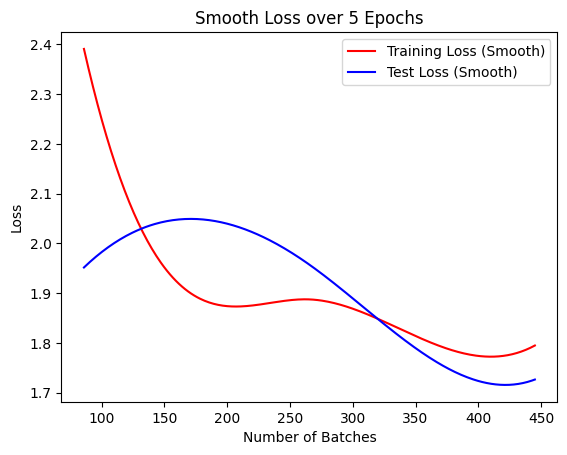

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
end_epoch = 5
# Interpolation for smoother curve
x_new = np.linspace(min(train_trial_number), max(train_trial_number), 300)
spl_train = make_interp_spline(train_trial_number, train_trial_loss, k=3)  # Cubic spline
spl_test = make_interp_spline(test_trial_number, test_trial_loss, k=3)

y_train_smooth = spl_train(x_new)
y_test_smooth = spl_test(x_new)

# Plotting smooth curves
plt.plot(x_new, y_train_smooth, 'r-', label='Training Loss (Smooth)')
plt.plot(x_new, y_test_smooth, 'b-', label='Test Loss (Smooth)')

plt.xlabel('Number of Batches')
plt.ylabel('Loss')
plt.title('Smooth Loss over ' + str(end_epoch) + ' Epochs')
plt.legend()
plt.show()


### Generating Hashtags
We generate hashtags and manually check their validity

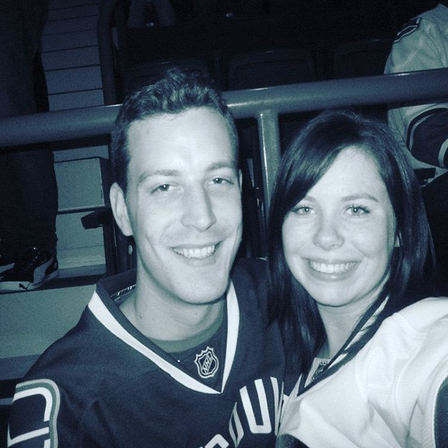

Actual: #throwbackthursday, #love, #boyfriend, #smile, #goodnight, #happy, #drink, #drunk, #bestfriend
Prediction: #boyfriend
Prediction: #<UNK>, #boyfriend
Prediction: #<UNK>
Prediction: #<UNK>, #love, #boyfriend
Prediction: #love, #boyfriend
Prediction: #<UNK>, #home
Prediction: #iloveyou, #boyfriend
Prediction: #boyfriend, #handsome
Prediction: #home
Prediction: #boyfriend, #girlfriend


C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [20]:
batched_data = batch_data(tag_list, 1, progress_bar=False)
batched_train_data, batched_test_data = create_splits(batched_data)
test_loader = get_loader(tag_list, batched_test_data, vocabulary, testing_transform, shuffle=True, num_workers=0)
for images, tags, image_ids in test_loader:
    if torch.cuda.is_available():
        images = images.cuda()
        tags = tags.cuda()
        
    image = Image.open("./HARRISON-Dataset/HARRISON/HARRISON_full/HARRISON/" + data_list[image_ids[0]])
    image = image.resize((448, 448), Image.Resampling.LANCZOS)
    display(image)
    print("Actual: #" + ", #".join(tag_list[image_ids[0]].split(" "))[:-3])
    image_features = encoder(images)
    predictions = decoder.sample(image_features, beam_size=10, start_token=vocabulary("<SOS>"), end_token=vocabulary("<EOS>"))
    for prediction in predictions:
        tags = [vocabulary(tag) for tag in prediction[1][:-1]]
        print("Prediction: #" + ", #".join(tags))
    del images, tags
    break

### Evaluating model based on precision,recall,f1-score and accuracy.

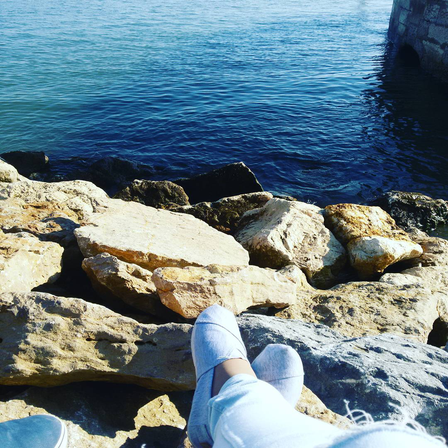

Actual: #sea, #
Prediction: #sea
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
Accuracy: 1.00


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import nltk

# Store results
all_precision = []
all_recall = []
all_f1 = []
all_accuracy = []

# Get all vocabulary words (adjust this based on your Vocabulary implementation)
vocab_words = [vocabulary(i) for i in range(len(vocabulary))]  # Example assuming indices map to words

# Loop through the test loader
for images, tags, image_ids in test_loader:
    if torch.cuda.is_available():
        images = images.cuda()
        tags = tags.cuda()

    # Load and display the image (optional for evaluation)
    image_path = f"./HARRISON-Dataset/HARRISON/HARRISON_full/HARRISON/{data_list[image_ids[0]]}"
    image = Image.open(image_path)
    image = image.resize((448, 448), Image.Resampling.LANCZOS)
    display(image)

    # Extract actual tags
    actual_tags = tag_list[image_ids[0]].split(" ")
    print("Actual: #" + ", #".join(actual_tags))

    # Get predictions from the decoder
    image_features = encoder(images)
    predictions = decoder.sample(image_features, beam_size=10, start_token=vocabulary("<SOS>"), end_token=vocabulary("<EOS>"))
    predicted_tags = [vocabulary(tag) for tag in predictions[0][1][:-1]]  # Best prediction
    print("Prediction: #" + ", #".join(predicted_tags))

    # Create binary vectors for actual and predicted tags
    actual_binary = [1 if word in actual_tags else 0 for word in vocab_words]
    predicted_binary = [1 if word in predicted_tags else 0 for word in vocab_words]

    # Compute metrics
    precision = precision_score(actual_binary, predicted_binary, zero_division=0)
    recall = recall_score(actual_binary, predicted_binary, zero_division=0)
    f1 = f1_score(actual_binary, predicted_binary, zero_division=0)
    accuracy = accuracy_score(actual_binary, predicted_binary)

    # Append metrics to the lists
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)
    all_accuracy.append(accuracy)

    # Break after one batch for reference (optional)
    break

# Print average metrics for the batch
print(f"Precision: {sum(all_precision) / len(all_precision):.2f}")
print(f"Recall: {sum(all_recall) / len(all_recall):.2f}")
print(f"F1-Score: {sum(all_f1) / len(all_f1):.2f}")
print(f"Accuracy: {sum(all_accuracy) / len(all_accuracy):.2f}")


### Generating multiple predictions by changing  beam_size

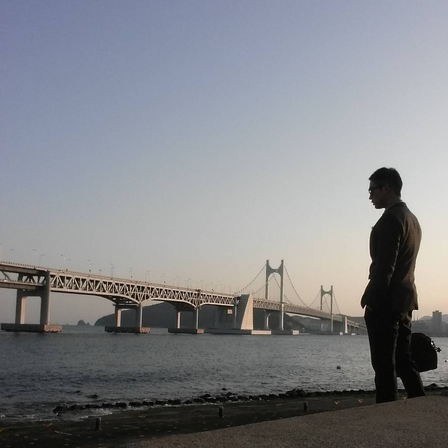

Actual: #follow, #, #instagood, #daily, #instagram, #sea, #monday, #like, #good, #morning
Prediction: #<UNK>
Prediction: #<UNK>, #sea
Prediction: #sea
Prediction: #home
Prediction: #sea, #beach, #sun, #sand
Prediction: #<UNK>, #home
Prediction: #<UNK>, #sea, #sun, #sand
Prediction: #<UNK>, #sea, #beach, #sand
Prediction: #<UNK>, #sea, #beach
Prediction: #sea, #beach, #sand
Precision: 1.00
Recall: 0.14
F1-Score: 0.25
Accuracy: 0.96


C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import nltk

# Store results
all_precision = []
all_recall = []
all_f1 = []
all_accuracy = []

# Get all vocabulary words (adjust this based on your Vocabulary implementation)
vocab_words = [vocabulary(i) for i in range(len(vocabulary))]  # Example assuming indices map to words

# Loop through the test loader
for images, tags, image_ids in test_loader:
    if torch.cuda.is_available():
        images = images.cuda()
        tags = tags.cuda()

    # Load and display the image (optional for evaluation)
    image_path = f"./HARRISON-Dataset/HARRISON/HARRISON_full/HARRISON/{data_list[image_ids[0]]}"
    image = Image.open(image_path)
    image = image.resize((448, 448), Image.Resampling.LANCZOS)
    display(image)

    # Extract actual tags (set of actual tags for this image)
    actual_tags = set(tag_list[image_ids[0]].split(" "))
    print("Actual: #" + ", #".join(actual_tags))

    # Get predictions from the decoder (set of predicted tags)
    image_features = encoder(images)
    predictions = decoder.sample(image_features, beam_size=10, start_token=vocabulary("<SOS>"), end_token=vocabulary("<EOS>"))
    for prediction in predictions:
        tags = [vocabulary(tag) for tag in prediction[1][:-1]]  # Best prediction
        print("Prediction: #" + ", #".join(tags))
    prediction_tags = set([vocabulary(tag) for tag in predictions[0][1][:-1]])
    # Create binary vectors for actual and predicted tags
    actual_binary = [1 if word in actual_tags else 0 for word in vocab_words]
    predicted_binary = [1 if word in predicted_tags else 0 for word in vocab_words]

    # Compute metrics
    precision = precision_score(actual_binary, predicted_binary, zero_division=0)
    recall = recall_score(actual_binary, predicted_binary, zero_division=0)
    f1 = f1_score(actual_binary, predicted_binary, zero_division=0)
    accuracy = accuracy_score(actual_binary, predicted_binary)

    # Append metrics to the lists
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)
    all_accuracy.append(accuracy)

    # Break after one batch for reference (optional)
    break

# Print average metrics for the batch
print(f"Precision: {sum(all_precision) / len(all_precision):.2f}")
print(f"Recall: {sum(all_recall) / len(all_recall):.2f}")
print(f"F1-Score: {sum(all_f1) / len(all_f1):.2f}")
print(f"Accuracy: {sum(all_accuracy) / len(all_accuracy):.2f}")


### Finding Hamming Loss
We generate the hash tags for each image and find the average hamming loss of the model

In [23]:
loss = 0
single_batched_data = batch_data(tag_list, 1, progress_bar=False)
single_batched_train_data, single_batched_test_data = create_splits(single_batched_data)
single_test_loader = get_loader(tag_list, single_batched_test_data, vocabulary, testing_transform, shuffle=True, num_workers=0)
for images, tags, image_ids in tqdm_notebook(single_test_loader):
    if torch.cuda.is_available():
        images = images.cuda()
        tags = tags.cuda()
        
    actual = nltk.tokenize.word_tokenize(tag_list[image_ids[0]].lower())
    image_features = encoder(images)
    predictions = decoder.sample(image_features, beam_size=10, start_token=vocabulary("<SOS>"), end_token=vocabulary("<EOS>"))
    best_prediction = predictions
    actual_tags = [1 if i in actual else 0 for i in range(len(vocabulary))]
    predicted_tags = [1 if i in best_prediction else 0 for i in range(len(vocabulary))]
    loss += hamming_loss(actual_tags, predicted_tags)
    del images, tags
print(loss / len(single_test_loader))

import torch
torch.cuda.is_available()

C:\Users\thiru\AppData\Local\Temp\ipykernel_14216\2788943216.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for images, tags, image_ids in tqdm_notebook(single_test_loader):


  0%|          | 0/1016 [00:00<?, ?it/s]

C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is depreca

0.0


C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
C:\Users\thiru\anaconda3\envs\my_env3\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


True

In [24]:
!pip freeze > requirements.txt


In [26]:
# Open the file and process each line
with open('requirements.txt', 'r') as file:
    lines = file.readlines()

# Remove '@' and everything after it in each line
cleaned_lines = [line.split('@')[0].strip() + '\n' for line in lines]

# Write the cleaned lines back to the file
with open('requirements.txt', 'w') as file:
    file.writelines(cleaned_lines)

print("Cleaned requirements.txt file successfully!")


Cleaned requirements.txt file successfully!
